In [1]:
!pip3 install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import BertForSequenceClassification,AutoTokenizer,Trainer,TrainingArguments
from datasets import load_dataset
import os

In [3]:
 os.environ["WANDB_DISABLED"] = "true"

 dataset = load_dataset("imdb")

 model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
 tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

 def preprocess_function(examples):
  return tokenizer(examples['text'],truncation=True,padding=True)

 encoded_dataset = dataset.map(preprocess_function,batched=True, batch_size=64)

train_set = encoded_dataset["train"].shuffle(seed=42)
test_set = encoded_dataset["test"]
indices = list(range(5000)) + list(range(len(test_set) - 5000, len(test_set)))
test_set = test_set.select(indices)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    num_train_epochs = 1
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_set,
    eval_dataset = test_set,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [6]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.207100,0.174532,0.936500,0.927355,0.947200,0.937172


TrainOutput(global_step=1563, training_loss=0.24064816226580932, metrics={'train_runtime': 2778.2214, 'train_samples_per_second': 8.999, 'train_steps_per_second': 0.563, 'total_flos': 6577776384000000.0, 'train_loss': 0.24064816226580932, 'epoch': 1.0})

In [7]:
eval_results = trainer.evaluate(test_set)

print("Evaluating fine-tuned BERT model")
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1-score: {eval_results['eval_f1']}")

Evaluating fine-tuned BERT model
Accuracy: 0.9365
Precision: 0.9273546113177991
Recall: 0.9472
F1-score: 0.9371722568516869


In [8]:
from transformers import BertModel

pretrained_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

pretrained_eval_training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=1,
    do_train=False,
    do_eval=True
)

pretrained_eval_trainer = Trainer(
    model=pretrained_model,
    args=training_args,
    eval_dataset=test_set,
    compute_metrics=compute_metrics,
)

pretrained_eval_results = pretrained_eval_trainer.evaluate(test_set)

print("Evaluating Pre-trained BERT Model")
print(f"Accuracy: {pretrained_eval_results['eval_accuracy']}")
print(f"Precision: {pretrained_eval_results['eval_precision']}")
print(f"Recall: {pretrained_eval_results['eval_recall']}")
print(f"F1-score: {pretrained_eval_results['eval_f1']}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Evaluating Pre-trained BERT Model
Accuracy: 0.4489
Precision: 0.4641000421525924
Recall: 0.6606
F1-score: 0.54518445159693


In [10]:
trainer.save_model("./fine_tuned_bert_imdb1")

from google.colab import drive
import torch

drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/fine_tuned_bert_imdb1.pth'

torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Mounted at /content/drive
Model saved to /content/drive/MyDrive/fine_tuned_bert_imdb.pth


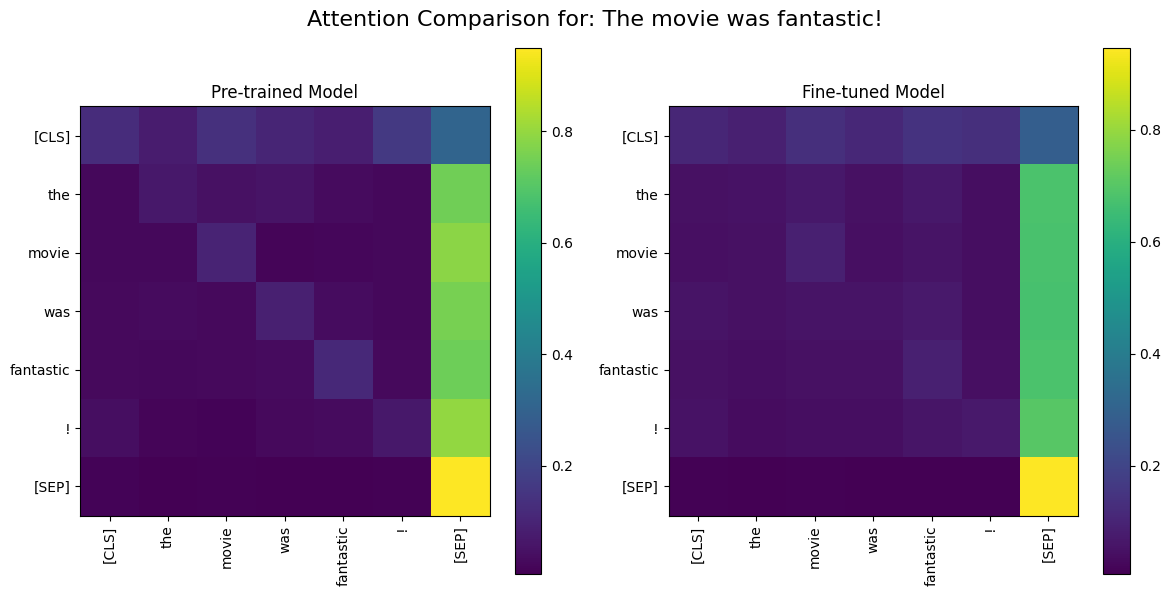

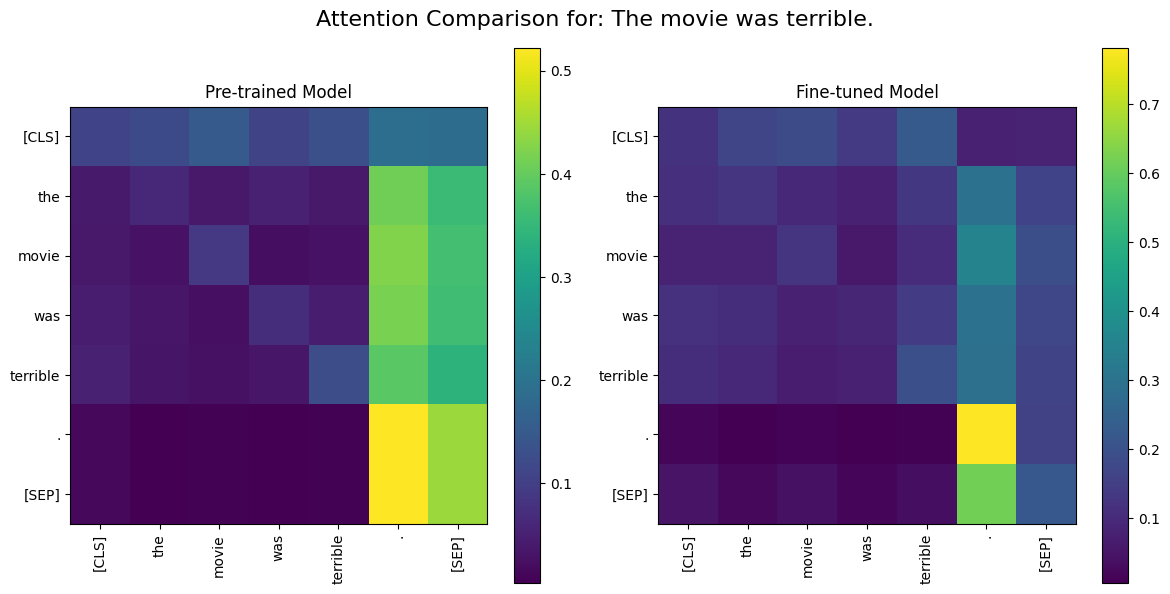

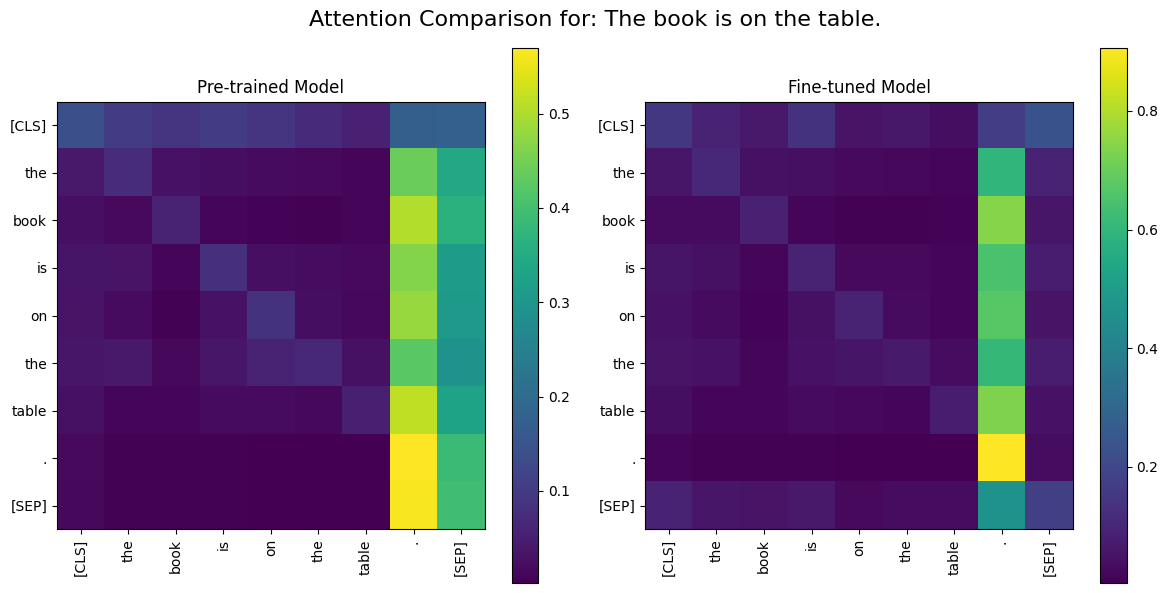

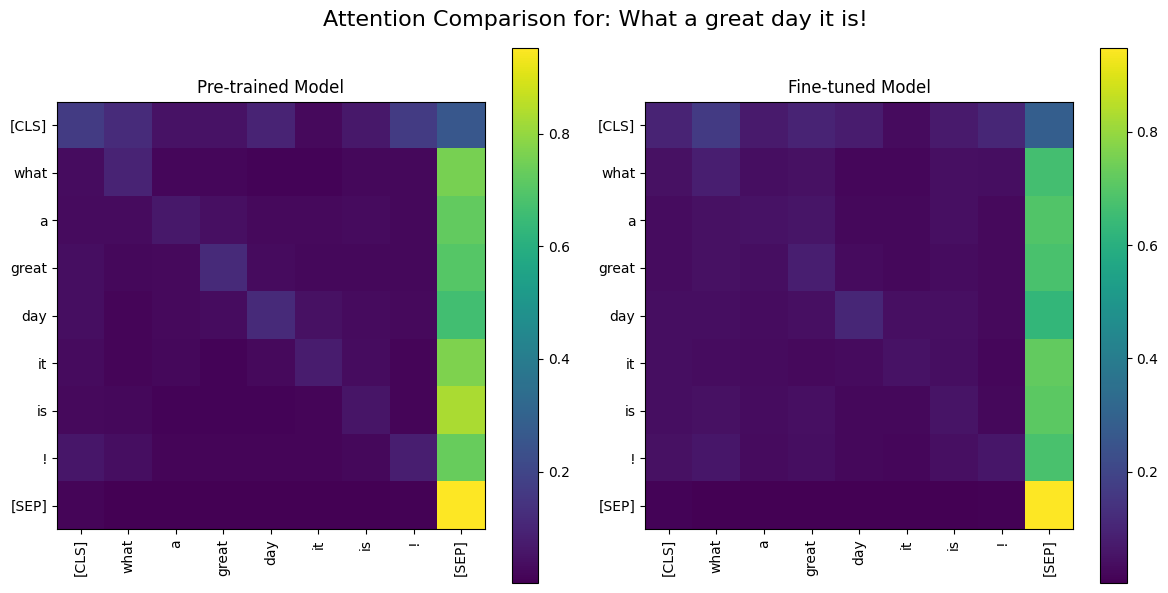

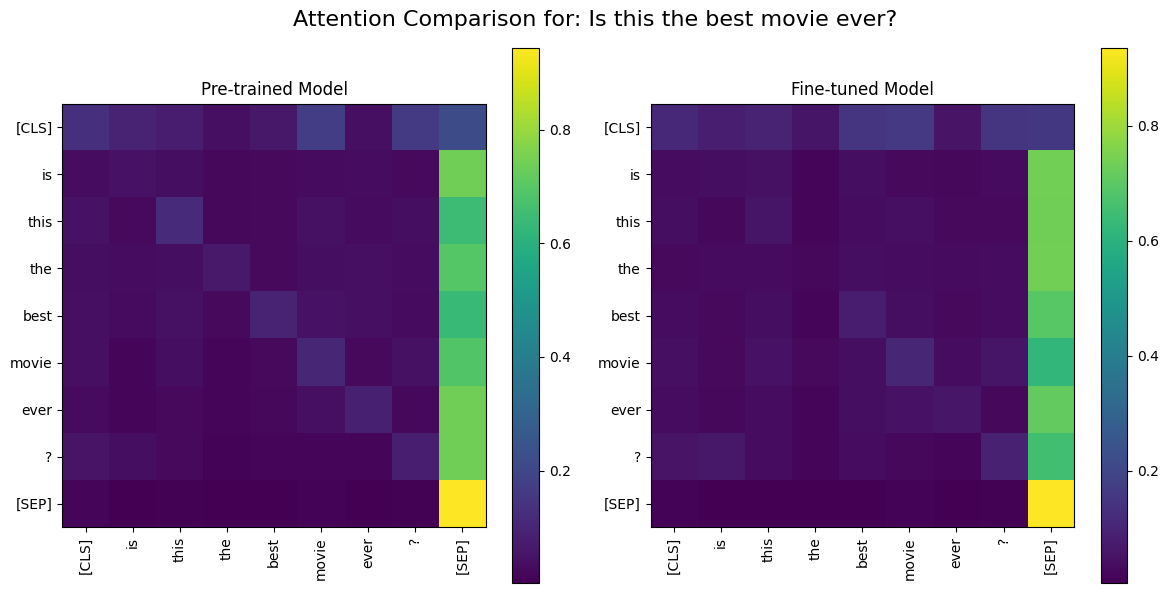

In [14]:
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt

pretrained_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
fine_tuned_model = BertModel.from_pretrained("./fine_tuned_bert_imdb", output_attentions=True)

def plot_attention_comparison_both_models(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")

    # 获取分词后的单词序列
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    seq_len = len(tokens)

    # 获取预训练模型的注意力
    pretrained_outputs = pretrained_model(**inputs)
    pretrained_attentions = pretrained_outputs.attentions[-1][0]

    # 获取微调模型的注意力
    fine_tuned_outputs = fine_tuned_model(**inputs)
    fine_tuned_attentions = fine_tuned_outputs.attentions[-1][0]

    # 绘制注意力比较图
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Attention Comparison for: {sentence}", fontsize=16)

    # 预训练模型
    ax1 = axes[0]
    cax1 = ax1.imshow(pretrained_attentions.mean(dim=0).detach().numpy(), cmap="viridis")
    ax1.set_title("Pre-trained Model")
    ax1.set_xticks(range(seq_len))
    ax1.set_yticks(range(seq_len))
    ax1.set_xticklabels(tokens, rotation=90)  # 设置 x 轴标签为分词单词
    ax1.set_yticklabels(tokens)  # 设置 y 轴标签为分词单词
    fig.colorbar(cax1, ax=ax1)

    # 微调模型
    ax2 = axes[1]
    cax2 = ax2.imshow(fine_tuned_attentions.mean(dim=0).detach().numpy(), cmap="viridis")
    ax2.set_title("Fine-tuned Model")
    ax2.set_xticks(range(seq_len))
    ax2.set_yticks(range(seq_len))
    ax2.set_xticklabels(tokens, rotation=90)  # 设置 x 轴标签为分词单词
    ax2.set_yticklabels(tokens)  # 设置 y 轴标签为分词单词
    fig.colorbar(cax2, ax=ax2)

    plt.tight_layout()
    plt.show()

# 示例句子
sentences = [
    "The movie was fantastic!",  # 情感正面
    "The movie was terrible.",   # 情感负面
    "The book is on the table.", # 中立句子
    "What a great day it is!",   # 感叹句
    "Is this the best movie ever?"  # 问句
]

# 逐句绘制注意力比较图
for sentence in sentences:
    plot_attention_comparison_both_models(sentence)
